## **Import** **Libraries** **bold text**

In [27]:
!pip install openai --quiet
import openai
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, timeit
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import Markdown as md, display

In [36]:
import openai
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
openai.api_key = os.getenv("OPENAI_API_KEY")

## **Create Mock Database**

In [29]:
products = [
    {"name": "Boho Dress", "desc": "Flowy dress with earthy tones, embroidered details - perfect festival boho vibes.", "tags": ["boho","festival","flowy"]},
    {"name": "Urban Bomber", "desc": "Cropped bomber jacket, sleek black, energetic urban chic streetwear.", "tags": ["urban","chic","street"]},
    {"name": "Cozy Knit Hoodie", "desc": "Oversized hoodie in soft knit, warm and snug - cozy homewear.", "tags": ["cozy","casual","loungewear"]},
    {"name": "Minimal Slip Dress", "desc": "Clean lines, satin slip, minimal and elegant - evening chic.", "tags": ["minimal","elegant","evening"]},
    {"name": "Sporty Runner", "desc": "Lightweight running jacket, breathable, for active and energetic looks.", "tags": ["sporty","energetic","active"]},
    {"name": "Vintage Denim", "desc": "High-waist distressed denim, retro-cool and laid-back.", "tags": ["vintage","retro","casual"]},
    {"name": "Tailored Blazer", "desc": "Structured blazer, sharp silhouette, office-to-night smart style.", "tags": ["formal","smart","sharp"]},
    {"name": "Summer Linen Set", "desc": "Linen top and shorts, breezy and relaxed - coastal summer vibes.", "tags": ["coastal","relaxed","summer"]},
]
df = pd.DataFrame(products)
display(df)

,name,desc,tags
0,Boho Dress,"Flowy dress with earthy tones, embroidered det...","[boho, festival, flowy]"
1,Urban Bomber,"Cropped bomber jacket, sleek black, energetic ...","[urban, chic, street]"
2,Cozy Knit Hoodie,"Oversized hoodie in soft knit, warm and snug -...","[cozy, casual, loungewear]"
3,Minimal Slip Dress,"Clean lines, satin slip, minimal and elegant -...","[minimal, elegant, evening]"
4,Sporty Runner,"Lightweight running jacket, breathable, for ac...","[sporty, energetic, active]"
5,Vintage Denim,"High-waist distressed denim, retro-cool and la...","[vintage, retro, casual]"
6,Tailored Blazer,"Structured blazer, sharp silhouette, office-to...","[formal, smart, sharp]"
7,Summer Linen Set,"Linen top and shorts, breezy and relaxed - coa...","[coastal, relaxed, summer]"


# **Create Embeddings**

In [30]:
def get_embeddings(texts, model="text-embedding-ada-002"):
    embeddings = []
    for t in texts:
        resp = openai.embeddings.create(input=t, model=model)
        emb = resp.data[0].embedding
        embeddings.append(emb)
    return np.array(embeddings)

In [31]:
print("Creating product embeddings...")
product_embeddings = get_embeddings(df["desc"].tolist())
print("Shape:", product_embeddings.shape)

Creating product embeddings...
Shape: (8, 1536)


# **Top 3 Results with Query Matching**

In [32]:
def top_k_matches(query, k=3, embeddings=product_embeddings, df=df, threshold=0.7):
    q_emb = get_embeddings([query])[0]
    sims = cosine_similarity([q_emb], embeddings)[0]
    top_idx = np.argsort(sims)[::-1][:k]
    results = []
    for i in top_idx:
        results.append({
            "rank": len(results)+1,
            "name": df.loc[i,"name"],
            "desc": df.loc[i,"desc"],
            "tags": df.loc[i,"tags"],
            "score": float(sims[i])
        })
    if results and results[0]["score"] < 0.3:
        return {"fallback": True, "message": "No strong match found — try a broader vibe", "results": results}
    return {"fallback": False, "results": results}

In [33]:
query = "energetic urban chic"
print("Query:", query)
output = top_k_matches(query)
pd.DataFrame(output["results"])

Query: energetic urban chic


,rank,name,desc,tags,score
0,1,Urban Bomber,"Cropped bomber jacket, sleek black, energetic ...","[urban, chic, street]",0.867462
1,2,Sporty Runner,"Lightweight running jacket, breathable, for ac...","[sporty, energetic, active]",0.824866
2,3,Tailored Blazer,"Structured blazer, sharp silhouette, office-to...","[formal, smart, sharp]",0.824502


In [34]:
queries = ["energetic urban chic", "cozy relaxed home", "festival boho vibes"]
logs = []
for q in queries:
    t0 = time.perf_counter()
    res = top_k_matches(q, k=3)
    t1 = time.perf_counter()
    top_score = res["results"][0]["score"] if res["results"] else 0.0
    good = top_score >= 0.7
    logs.append({
        "query": q,
        "top_score": top_score,
        "good": good,
        "fallback": res.get("fallback", False),
        "latency_ms": (t1 - t0) * 1000
    })

log_df = pd.DataFrame(logs)
display(log_df)

,query,top_score,good,fallback,latency_ms
0,energetic urban chic,0.867462,True,False,196.640169
1,cozy relaxed home,0.850940,True,False,169.447676
2,festival boho vibes,0.879850,True,False,211.457394


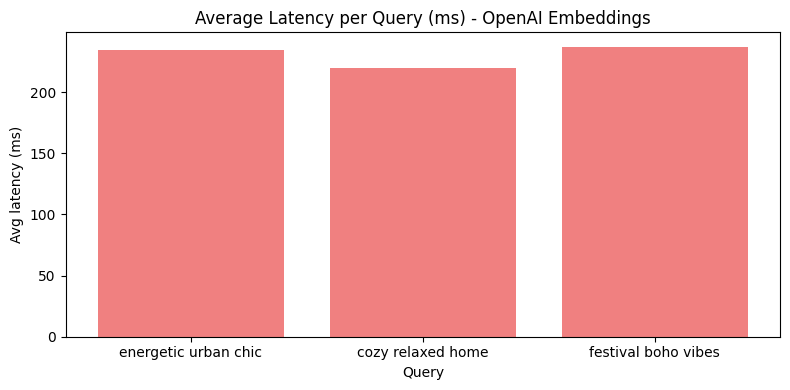

In [35]:
repeats = 10
timings = {}
for l in logs:
    q = l["query"]
    stmt = f"top_k_matches('{q}', k=3)"
    t = timeit.timeit(stmt, globals=globals(), number=repeats)
    timings[q] = (t / repeats) * 1000

plt.figure(figsize=(8,4))
plt.bar(list(timings.keys()), list(timings.values()), color='lightcoral')
plt.title("Average Latency per Query (ms) - OpenAI Embeddings")
plt.ylabel("Avg latency (ms)")
plt.xlabel("Query")
plt.tight_layout()
plt.show()

In [38]:
display(md("""
###  Reflection — Improvements
- Use **Pinecone / FAISS** for scalable and persistent vector search.
- Add **multi-attribute filtering** (e.g., price, color, gender).
- Implement **personalized re-ranking** based on past preferences.
- Handle **short/ambiguous queries** by prompting for clarification.
- Consider **text-embedding-3-large** for higher accuracy in semantic retrieval.
"""))


###  Reflection — Improvements
- Use **Pinecone / FAISS** for scalable and persistent vector search.
- Add **multi-attribute filtering** (e.g., price, color, gender).
- Implement **personalized re-ranking** based on past preferences.
- Handle **short/ambiguous queries** by prompting for clarification.
- Consider **text-embedding-3-large** for higher accuracy in semantic retrieval.
